## Link: https://rubikscode.net/2018/12/17/implementing-gan-dcgan-with-python/

In [1]:
import tensorflow as tf
print(tf.__version__)
%mkdir generated-dcgan

2.7.0


## Helper class

In [2]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt

class ImageHelper(object):
    def save_image(self, generated, epoch, directory):
        fig, axs = plt.subplots(5, 5)
        count = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(generated[count, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                count += 1
        fig.savefig("{}/{}.png".format(directory, epoch))
        plt.close()
        
    def makegif(self, directory):
        filenames = np.sort(os.listdir(directory))
        filenames = [ fnm for fnm in filenames if ".png" in fnm]
    
        with imageio.get_writer(directory + '/image.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(directory + filename)
                writer.append_data(image)

## Gan model

In [3]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras modules
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

class DCGAN():
    def __init__(self, image_shape, generator_input_dim, image_hepler, img_channels):
        optimizer = Adam(0.0002, 0.5)
        
        self._image_helper = image_hepler
        self.img_shape = image_shape
        self.generator_input_dim = generator_input_dim
        self.channels = img_channels

        # Build models
        self._build_generator_model()
        self._build_and_compile_discriminator_model(optimizer)
        self._build_and_compile_gan(optimizer)

    def train(self, epochs, train_data, batch_size):
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):
            #  Train Discriminator
            batch_indexes = np.random.randint(0, train_data.shape[0], batch_size)
            batch = train_data[batch_indexes]
            genenerated = self._predict_noise(batch_size)
            loss_real = self.discriminator_model.train_on_batch(batch, real)
            loss_fake = self.discriminator_model.train_on_batch(genenerated, fake)
            discriminator_loss = 0.5 * np.add(loss_real, loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.generator_input_dim))
            generator_loss = self.gan.train_on_batch(noise, real)

            # Plot the progress
            print ("---------------------------------------------------------")
            print ("******************Epoch {}***************************".format(epoch))
            print ("Discriminator loss: {}".format(discriminator_loss[0]))
            print ("Generator loss: {}".format(generator_loss))
            print ("---------------------------------------------------------")
            
            history.append({"D":discriminator_loss[0],"G":generator_loss})
            
            # Save images from every hundereth epoch generated images
            if epoch % 100 == 0:
                self._save_images(epoch)
                
        self._plot_loss(history)
        self._image_helper.makegif("generated-dcgan/")        
    
    def _build_generator_model(self):
        generator_input = Input(shape=(self.generator_input_dim,))
        generator_seqence = Sequential(
                [Dense(128 * 7 * 7, activation="relu", input_dim=self.generator_input_dim),
                 Reshape((7, 7, 128)),
                 UpSampling2D(),
                 Conv2D(128, kernel_size=3, padding="same"),
                 BatchNormalization(momentum=0.8),
                 Activation("relu"),
                 UpSampling2D(),
                 Conv2D(64, kernel_size=3, padding="same"),
                 BatchNormalization(momentum=0.8),
                 Activation("relu"),
                 Conv2D(self.channels, kernel_size=3, padding="same"),
                 Activation("tanh")])
    
        generator_output_tensor = generator_seqence(generator_input)       
        self.generator_model = Model(generator_input, generator_output_tensor)
        
    def _build_and_compile_discriminator_model(self, optimizer):
        discriminator_input = Input(shape=self.img_shape)
        discriminator_sequence = Sequential(
                [Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"),
                 LeakyReLU(alpha=0.2),
                 Dropout(0.25),
                 Conv2D(64, kernel_size=3, strides=2, padding="same"),
                 ZeroPadding2D(padding=((0,1),(0,1))),
                 BatchNormalization(momentum=0.8),
                 LeakyReLU(alpha=0.2),
                 Dropout(0.25),
                 Conv2D(128, kernel_size=3, strides=2, padding="same"),
                 BatchNormalization(momentum=0.8),
                 LeakyReLU(alpha=0.2),
                 Dropout(0.25),
                 Conv2D(256, kernel_size=3, strides=2, padding="same"),
                 BatchNormalization(momentum=0.8),
                 LeakyReLU(alpha=0.2),
                 Dropout(0.25),
                 Flatten(),
                 Dense(1, activation='sigmoid')])
    
        discriminator_tensor = discriminator_sequence(discriminator_input)
        self.discriminator_model = Model(discriminator_input, discriminator_tensor)
        self.discriminator_model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.discriminator_model.trainable = False
    
    def _build_and_compile_gan(self, optimizer):
        real_input = Input(shape=(self.generator_input_dim,))
        generator_output = self.generator_model(real_input)
        discriminator_output = self.discriminator_model(generator_output)        
        
        self.gan = Model(real_input, discriminator_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def _save_images(self, epoch):
        generated = self._predict_noise(25)
        generated = 0.5 * generated + 0.5
        self._image_helper.save_image(generated, epoch, "generated-dcgan/")
    
    def _predict_noise(self, size):
        noise = np.random.normal(0, 1, (size, self.generator_input_dim))
        return self.generator_model.predict(noise)
        
    def _plot_loss(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()

## Usage


Streaming output truncated to the last 5000 lines.
---------------------------------------------------------
******************Epoch 19000***************************
Discriminator loss: 1.5812663678449468e-10
Generator loss: 0.052633754909038544
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 19001***************************
Discriminator loss: 8.151189445637641e-11
Generator loss: 0.05180402100086212
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 19002***************************
Discriminator loss: 8.852067689968379e-11
Generator loss: 0.03709013760089874
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 19003***************************
Discriminator loss: 3.2877876116055305e-10
Generator loss: 0.13639281690120697


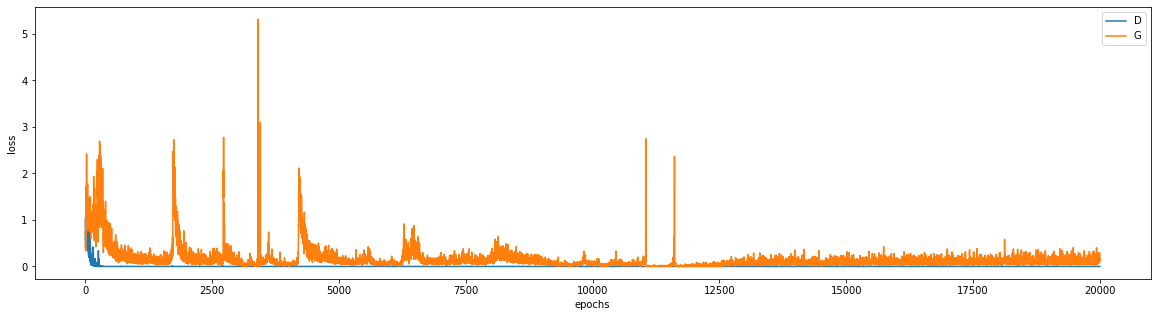

In [4]:
import numpy as np
from keras.datasets import fashion_mnist



(X, _), (_, _) = fashion_mnist.load_data()
X_train = X / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

image_helper = ImageHelper()
generative_advarsial_network = DCGAN(X_train[0].shape, 100, image_helper, 1)
generative_advarsial_network.train(20000, X_train, batch_size=32)

In [5]:
%ls generated-dcgan

0.png      12400.png  1500.png   17700.png  2300.png  5000.png  7600.png
10000.png  12500.png  15100.png  17800.png  2400.png  500.png   7700.png
1000.png   12600.png  15200.png  17900.png  2500.png  5100.png  7800.png
100.png    12700.png  15300.png  18000.png  2600.png  5200.png  7900.png
10100.png  12800.png  15400.png  1800.png   2700.png  5300.png  8000.png
10200.png  12900.png  15500.png  18100.png  2800.png  5400.png  800.png
10300.png  13000.png  15600.png  18200.png  2900.png  5500.png  8100.png
10400.png  1300.png   15700.png  18300.png  3000.png  5600.png  8200.png
10500.png  13100.png  15800.png  18400.png  300.png   5700.png  8300.png
10600.png  13200.png  15900.png  18500.png  3100.png  5800.png  8400.png
10700.png  13300.png  16000.png  18600.png  3200.png  5900.png  8500.png
10800.png  13400.png  1600.png   18700.png  3300.png  6000.png  8600.png
10900.png  13500.png  16100.png  18800.png  3400.png  600.png   8700.png
11000.png  13600.png  16200.png  18900.png  3500.png

In [6]:
from IPython.display import Image
Image(open('generated-dcgan/image.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [7]:
(X, _), (_, _) = fashion_mnist.load_data()
print(X.shape)
X_train = X / 127.5 - 1.
X_apein = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28)
